# Acheiving 99.4% accuracy in MNIST in a HIGHLY resource constrained system
---

## Constraints:
- Parameters should be less than 10,000
- Accuracy to be achieved in less than 15 epochs

## Progress in this notebook
- Since I had already done some iterations in the previous [assignment](https://github.com/sairamsubramaniam/tsai_projects/tree/master/assignment2_MNIST), the easiest way to start was to take the previous model, reduce parameters to below 10k and see how the model performed.
- The model gave an accuracy of 99.27% (**99.21%** avg in last 5 epochs) with just **6,246** params in **20** epochs

## The model consists of:
- Contains 8 layers with following number of kernels:
  - Conv 8 -> Conv 8 -> Bottlenck -> Conv 16 -> Conv 16 -> Conv 8 -> Conv 0 -> GAP
  - Bottleneck layer = Maxpool + 1x1 Conv
- Only 3x3 convolution used everywhere (except for the bottleneck & GAP layers
- Except the bottleneck & last Conv layer, every convolution is followed by "RELU" & "Batch Normalization"
- No padding has been used anywhere

---

## SCRIPT SECTION
---

### Setup Google Drive for saving / reloading previous saved values

In [1]:
from google.colab import drive
drive.mount("/content/drive")

base_folder = 'drive/My Drive/eva_stored_from_colab/eva5/mnist_0994_10k/'
acc_recorder_file = "highest_accuracy_achieved"
model_file_name = "base_model"

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


### Import required modules

In [2]:
from __future__ import print_function
from operator import itemgetter
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

### The Network Architecture

In [5]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 8, 3)
        self.bn1 = nn.BatchNorm2d(8)
        self.conv2 = nn.Conv2d(8, 8, 3)
        self.bn2 = nn.BatchNorm2d(8)
        self.pool1 = nn.MaxPool2d(2, 2)
        self.antman = nn.Conv2d(8, 8, 1)
        self.conv3 = nn.Conv2d(8, 16, 3)
        self.bn3 = nn.BatchNorm2d(16)
        self.conv4 = nn.Conv2d(16, 16, 3)
        self.bn4 = nn.BatchNorm2d(16)
        self.conv5 = nn.Conv2d(16, 8, 3)
        self.bn5 = nn.BatchNorm2d(8)
        self.conv6 = nn.Conv2d(8, 10, 3)
        self.bn6 = nn.BatchNorm2d(10)
        self.gap = nn.AvgPool2d(4)

    def forward(self, x):
        x = self.bn1(F.relu(self.conv1(x)))
        x = self.bn2(F.relu(self.conv2(x)))
        x = self.antman(self.pool1(x))
        x = self.bn3(F.relu(self.conv3(x)))
        x = self.bn4(F.relu(self.conv4(x)))
        x = self.bn5(F.relu(self.conv5(x)))
        x = self.gap(self.bn6(self.conv6(x)))
        x = x.view(-1, 10)
        return F.log_softmax(x, dim=1)

### Calculating total parameters

In [6]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 26, 26]              80
       BatchNorm2d-2            [-1, 8, 26, 26]              16
            Conv2d-3            [-1, 8, 24, 24]             584
       BatchNorm2d-4            [-1, 8, 24, 24]              16
         MaxPool2d-5            [-1, 8, 12, 12]               0
            Conv2d-6            [-1, 8, 12, 12]              72
            Conv2d-7           [-1, 16, 10, 10]           1,168
       BatchNorm2d-8           [-1, 16, 10, 10]              32
            Conv2d-9             [-1, 16, 8, 8]           2,320
      BatchNorm2d-10             [-1, 16, 8, 8]              32
           Conv2d-11              [-1, 8, 6, 6]           1,160
      BatchNorm2d-12              [-1, 8, 6, 6]              16
           Conv2d-13             [-1, 10, 4, 4]             730
      BatchNorm2d-14             [-1, 1

### Downloading the MNIST dataset

In [7]:
torch.manual_seed(1)
batch_size = 128

kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=True, download=True,
                    transform=transforms.Compose([
                        transforms.ToTensor(),
                        transforms.Normalize((0.1307,), (0.3081,))
                    ])),
    batch_size=batch_size, shuffle=True, **kwargs)
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=False, transform=transforms.Compose([
                        transforms.ToTensor(),
                        transforms.Normalize((0.1307,), (0.3081,))
                    ])),
    batch_size=batch_size, shuffle=True, **kwargs)


Extracting ../data/MNIST/raw/train-images-idx3-ubyte.gz to ../data/MNIST/raw


Extracting ../data/MNIST/raw/train-labels-idx1-ubyte.gz to ../data/MNIST/raw



Extracting ../data/MNIST/raw/t10k-images-idx3-ubyte.gz to ../data/MNIST/raw


Extracting ../data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/MNIST/raw
Processing...
Done!


/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:469: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


### Defining train & test functions

In [8]:
from tqdm import tqdm
def train(model, device, train_loader, optimizer, epoch):
    model.train()
    train_loss = 0
    correct = 0
    pbar = tqdm(train_loader)
    for batch_idx, (data, target) in enumerate(pbar):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        train_loss += loss.item()
        pred = output.argmax(dim=1, keepdim=True)
        correct += pred.eq(target.view_as(pred)).sum().item()

        loss.backward()
        optimizer.step()
        pbar.set_description(desc= f'loss={loss.item()} batch_id={batch_idx}')
    
    total_imgs = len(train_loader.dataset)
    train_loss /= total_imgs
    accuracy = 100. * correct / total_imgs

    print('\nTrain Data: Average loss: {:.4f}, Accuracy: {}/{} ({:.4f}%)\n'.format(
        train_loss, correct, total_imgs, accuracy)
    )
    
    return train_loss, accuracy


def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.4f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    return test_loss, correct / len(test_loader.dataset)

def record_max_acc(max_acc):
    f = open(base_folder+acc_recorder_file, "w")
    f.write(str(max_acc))
    f.close()

### Training for 20 epochs

In [9]:
model = Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

start = time.time()
test_acc = []
train_acc = []

try:
    with open(base_folder+acc_recorder_file, "r") as infl:
        max_acc = float(infl.read().strip())
except:
    max_acc = 0.0

print("\nLAST RECORDED MAX ACCURACY: ", max_acc)
for epoch in range(1, 21):
    ep_start = time.time()
    print()
    print("EPOCH NUM {}".format(epoch))
    trl, tra = train(model, device, train_loader, optimizer, epoch)
    tsl, tsa = test(model, device, test_loader)
    test_acc.append(tsa)
    train_acc.append(tra)
    if tsa > max_acc:
        max_acc = tsa
        torch.save(model.state_dict(), base_folder+model_file_name+"_sd.pth")
        record_max_acc(max_acc)
    print("-----------------------------------------------")
print("TOTAL TRAINING TIME: ", time.time() - start)
print("LAST 10 EPOCH AVG ACC: ", sum(test_acc[-10:]) / len(test_acc[-10:]) )
print("LAST 5 EPOCH AVG ACC: ", sum(test_acc[-5:]) / len(test_acc[-5:]) )
print("MAX ACCURACY: ", max(test_acc))

  0%|          | 0/469 [00:00<?, ?it/s]


LAST RECORDED MAX ACCURACY:  0.0

EPOCH NUM 1


loss=0.17744459211826324 batch_id=468: 100%|██████████| 469/469 [00:20<00:00, 23.12it/s]


Train Data: Average loss: 0.0030, Accuracy: 56252/60000 (93.7533%)




  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1145, Accuracy: 9800/10000 (98.0000%)

-----------------------------------------------

EPOCH NUM 2


loss=0.0900941714644432 batch_id=468: 100%|██████████| 469/469 [00:20<00:00, 22.88it/s]


Train Data: Average loss: 0.0008, Accuracy: 58894/60000 (98.1567%)




  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0669, Accuracy: 9877/10000 (98.7700%)

-----------------------------------------------

EPOCH NUM 3


loss=0.03477863594889641 batch_id=468: 100%|██████████| 469/469 [00:20<00:00, 22.94it/s]


Train Data: Average loss: 0.0005, Accuracy: 59153/60000 (98.5883%)




  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0527, Accuracy: 9886/10000 (98.8600%)

-----------------------------------------------

EPOCH NUM 4


loss=0.056801680475473404 batch_id=468: 100%|██████████| 469/469 [00:20<00:00, 23.09it/s]


Train Data: Average loss: 0.0005, Accuracy: 59213/60000 (98.6883%)




  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0566, Accuracy: 9871/10000 (98.7100%)

-----------------------------------------------

EPOCH NUM 5


loss=0.02917858399450779 batch_id=468: 100%|██████████| 469/469 [00:20<00:00, 22.97it/s]


Train Data: Average loss: 0.0004, Accuracy: 59286/60000 (98.8100%)




  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0421, Accuracy: 9895/10000 (98.9500%)

-----------------------------------------------

EPOCH NUM 6


loss=0.08517718315124512 batch_id=468: 100%|██████████| 469/469 [00:20<00:00, 23.06it/s]


Train Data: Average loss: 0.0003, Accuracy: 59377/60000 (98.9617%)




  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0363, Accuracy: 9920/10000 (99.2000%)

-----------------------------------------------

EPOCH NUM 7


loss=0.02300856076180935 batch_id=468: 100%|██████████| 469/469 [00:20<00:00, 23.03it/s]


Train Data: Average loss: 0.0003, Accuracy: 59404/60000 (99.0067%)




  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0355, Accuracy: 9922/10000 (99.2200%)

-----------------------------------------------

EPOCH NUM 8


loss=0.017536429688334465 batch_id=468: 100%|██████████| 469/469 [00:20<00:00, 22.95it/s]


Train Data: Average loss: 0.0003, Accuracy: 59431/60000 (99.0517%)




  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0329, Accuracy: 9921/10000 (99.2100%)

-----------------------------------------------

EPOCH NUM 9


loss=0.023182176053524017 batch_id=468: 100%|██████████| 469/469 [00:20<00:00, 23.29it/s]


Train Data: Average loss: 0.0003, Accuracy: 59467/60000 (99.1117%)




  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0344, Accuracy: 9902/10000 (99.0200%)

-----------------------------------------------

EPOCH NUM 10


loss=0.013384117744863033 batch_id=468: 100%|██████████| 469/469 [00:20<00:00, 22.98it/s]


Train Data: Average loss: 0.0003, Accuracy: 59507/60000 (99.1783%)




  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0322, Accuracy: 9923/10000 (99.2300%)

-----------------------------------------------

EPOCH NUM 11


loss=0.011520877480506897 batch_id=468: 100%|██████████| 469/469 [00:20<00:00, 23.44it/s]


Train Data: Average loss: 0.0002, Accuracy: 59504/60000 (99.1733%)




  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0322, Accuracy: 9913/10000 (99.1300%)

-----------------------------------------------

EPOCH NUM 12


loss=0.05631355941295624 batch_id=468: 100%|██████████| 469/469 [00:19<00:00, 23.48it/s]


Train Data: Average loss: 0.0002, Accuracy: 59588/60000 (99.3133%)




  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0360, Accuracy: 9903/10000 (99.0300%)

-----------------------------------------------

EPOCH NUM 13


loss=0.014184308238327503 batch_id=468: 100%|██████████| 469/469 [00:20<00:00, 23.11it/s]


Train Data: Average loss: 0.0002, Accuracy: 59570/60000 (99.2833%)




  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0275, Accuracy: 9920/10000 (99.2000%)

-----------------------------------------------

EPOCH NUM 14


loss=0.026238270103931427 batch_id=468: 100%|██████████| 469/469 [00:19<00:00, 23.49it/s]


Train Data: Average loss: 0.0002, Accuracy: 59624/60000 (99.3733%)




  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0282, Accuracy: 9914/10000 (99.1400%)

-----------------------------------------------

EPOCH NUM 15


loss=0.09691625833511353 batch_id=468: 100%|██████████| 469/469 [00:19<00:00, 23.52it/s]


Train Data: Average loss: 0.0002, Accuracy: 59607/60000 (99.3450%)




  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0291, Accuracy: 9924/10000 (99.2400%)

-----------------------------------------------

EPOCH NUM 16


loss=0.043904200196266174 batch_id=468: 100%|██████████| 469/469 [00:20<00:00, 23.31it/s]


Train Data: Average loss: 0.0002, Accuracy: 59642/60000 (99.4033%)




  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0273, Accuracy: 9927/10000 (99.2700%)

-----------------------------------------------

EPOCH NUM 17


loss=0.010648790746927261 batch_id=468: 100%|██████████| 469/469 [00:19<00:00, 23.54it/s]


Train Data: Average loss: 0.0002, Accuracy: 59632/60000 (99.3867%)




  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0312, Accuracy: 9914/10000 (99.1400%)

-----------------------------------------------

EPOCH NUM 18


loss=0.021242961287498474 batch_id=468: 100%|██████████| 469/469 [00:20<00:00, 23.38it/s]


Train Data: Average loss: 0.0002, Accuracy: 59663/60000 (99.4383%)




  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0282, Accuracy: 9922/10000 (99.2200%)

-----------------------------------------------

EPOCH NUM 19


loss=0.0047307200729846954 batch_id=468: 100%|██████████| 469/469 [00:19<00:00, 23.46it/s]


Train Data: Average loss: 0.0002, Accuracy: 59663/60000 (99.4383%)




  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0250, Accuracy: 9925/10000 (99.2500%)

-----------------------------------------------

EPOCH NUM 20


loss=0.07272327691316605 batch_id=468: 100%|██████████| 469/469 [00:20<00:00, 23.42it/s]


Train Data: Average loss: 0.0002, Accuracy: 59688/60000 (99.4800%)




Test set: Average loss: 0.0289, Accuracy: 9917/10000 (99.1700%)

-----------------------------------------------
TOTAL TRAINING TIME:  454.823787689209
LAST 10 EPOCH AVG ACC:  0.99179
LAST 5 EPOCH AVG ACC:  0.9921000000000001
MAX ACCURACY:  0.9927


### Chart - Train vs Test accuracy for each epoch

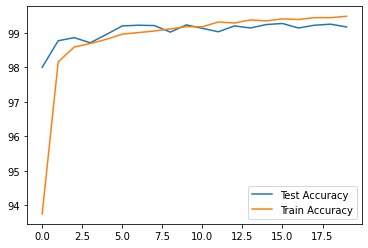

In [10]:
from matplotlib import pyplot as plt
%matplotlib inline

xaxis = list(range(len(test_acc)))
new_test_acc = [x*100.0 for x in test_acc]

plt.plot(xaxis, new_test_acc, label="Test Accuracy")
plt.plot(xaxis, train_acc, label="Train Accuracy")
plt.legend()
plt.show()